# Motivation

- There is a non-negligible number of homonyms in financial named entities such as company names
- E.g., 6.3% of the Korean company names are homonyms
- Assume we simply test if specific patterns like financial named entities are contained within a corpus
- Then we are likely to find a significant number of false positives by homonyms. 

In [1]:
import requests
import tarfile
import os
import math
import pandas as pd
from pandarallel import pandarallel
import dart_fss as dart
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display
pandarallel.initialize(progress_bar=True, use_memory_fs=True)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Loading MeCab vocabulary

- We can request an API key `dart_api_key` from `https://opendart.fss.or.kr/uss/umt/EgovMberInsertView.do`

In [2]:
mecab_ko_dic_url = 'https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz'
mecab_ko_dic_directory = './mecab-ko-dic-2.1.1-20180720'
dart_api_key = 'dc8906f388bd20a26e3ff03f5eddc9c7fa2f2303'

In [3]:
!curl -LO $mecab_ko_dic_url
!tar zxfv mecab-ko-dic-2.1.1-20180720.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 47.4M  100 47.4M    0     0  2206k      0  0:00:22  0:00:22 --:--:-- 4574k
mecab-ko-dic-2.1.1-20180720/
mecab-ko-dic-2.1.1-20180720/configure
mecab-ko-dic-2.1.1-20180720/COPYING
mecab-ko-dic-2.1.1-20180720/autogen.sh
mecab-ko-dic-2.1.1-20180720/Place-station.csv
mecab-ko-dic-2.1.1-20180720/NNG.csv
mecab-ko-dic-2.1.1-20180720/README
mecab-ko-dic-2.1.1-20180720/EF.csv
mecab-ko-dic-2.1.1-20180720/MAG.csv
mecab-ko-dic-2.1.1-20180720/Preanalysis.csv
mecab-ko-dic-2.1.1-20180720/NNB.csv
mecab-ko-dic-2.1.1-20180720/Person-actor.csv
mecab-ko-dic-2.1.1-20180720/VV.csv
mecab-ko-dic-2.1.1-20180720/Makefile.in
mecab-ko-dic-2.1.1-20180720/matrix.def
mecab-ko-dic-2.1.1-20180720/EC.csv
mecab-ko-dic-2.1.1-20180720/NNBC.csv
mecab-ko-dic-2.1.1-20180720/clean
mecab-ko-

In [4]:
def load_mecab_ko_dic_vocabulary(source_directory):
    result = list()
    columns = [
        '표층형', 'left-ID', 'right-ID', '비용', 
        '품사', '의미 부류', '종성 유무', '읽기', 
        '타입', '첫번째 품사', '마지막 품사', '표현'
    ]

    entries = os.listdir(source_directory)
    for idx, entry in enumerate(entries):
        # 'Wikipedia.csv' includes some of company names
        if entry in ['Wikipedia.csv']: continue
        entry_path = os.path.join(source_directory, entry)
        if os.path.isdir(entry_path): continue
        filename, extension = os.path.splitext(entry)
        if not extension == '.csv': continue
        
        dataframe = pd.read_csv(
            entry_path, 
            header=None, 
            names=columns,
        )
        dataframe.insert(dataframe.shape[1], '소스', entry)
        result.append(dataframe)
    
    result = pd.concat(result, axis=0, ignore_index=True)
    return result

In [5]:
vocabulary = load_mecab_ko_dic_vocabulary(mecab_ko_dic_directory)

In [6]:
vocabulary

,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
0,가가호호,735,2649,3337,MAG,성분부사|양태부사,F,가가호호,*,*,*,*,MAG.csv
1,가각히,726,2633,4017,MAG,*,F,가각히,*,*,*,*,MAG.csv
2,가강히,726,2633,4017,MAG,*,F,가강히,*,*,*,*,MAG.csv
3,가공스레,726,2633,4017,MAG,*,F,가공스레,*,*,*,*,MAG.csv
4,가관스레,726,2633,4017,MAG,*,F,가관스레,*,*,*,*,MAG.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779516,쿠노,2,3,2124,EC,*,F,쿠노,*,*,*,*,EC.csv
779517,티,2,3,3500,EC,*,F,티,*,*,*,*,EC.csv
779518,하고,2,3,3327,EC,*,F,하고,*,*,*,*,EC.csv
779519,히,2,3,5168,EC,*,F,히,*,*,*,*,EC.csv


## Loading Korean company names

In [7]:
def load_korean_companies(dart_api_key):
    dart.set_api_key(api_key=dart_api_key)
    result = dart.get_corp_list()
    return result

In [8]:
korean_companies = load_korean_companies(dart_api_key)

Output()

Output()

Output()

In [9]:
korean_companies

Number of companies: 96943

In [10]:
korean_companies[-1]

Label,Data
corp_code,01143737
corp_name,에이치엠지글로벌
stock_code,None
modify_date,20221114


In [11]:
korean_company_names = pd.Series([company.corp_name for company in tqdm(korean_companies)])

100%|██████████| 96943/96943 [00:00<00:00, 433951.71it/s]


In [12]:
korean_company_names[:10]

0                   다코
1                 일산약품
2                굿앤엘에스
3                 한라판지
4    크레디피아제이십오차유동화전문회사
5               연방건설산업
6       브룩스피알아이오토메이션잉크
7              매경아이비아이
8                 캐드뱅크
9     엠와이오피삼차유동화전문유한회사
dtype: object

## Separating homonyms and non-homonyms

In [13]:
homonym_indices = vocabulary['표층형'].isin(korean_company_names)

In [14]:
homonym_indices

0         False
1         False
2         False
3         False
4         False
          ...  
779516    False
779517    False
779518    False
779519    False
779520    False
Name: 표층형, Length: 779521, dtype: bool

In [15]:
homonyms = vocabulary[homonym_indices]

In [16]:
homonyms

,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
300,강동,726,2634,4054,MAG,*,T,강동,*,*,*,*,MAG.csv
728,고리,726,2633,4265,MAG,*,F,고리,*,*,*,*,MAG.csv
1042,구구,726,2633,4340,MAG,*,F,구구,*,*,*,*,MAG.csv
1539,기연,726,2634,4092,MAG,*,T,기연,*,*,*,*,MAG.csv
1581,길,726,2634,6255,MAG,*,T,길,*,*,*,*,MAG.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779500,지비,2,3,2124,EC,*,F,지비,*,*,*,*,EC.csv
779503,지우,2,3,2277,EC,*,F,지우,*,*,*,*,EC.csv
779504,지유,2,3,2156,EC,*,F,지유,*,*,*,*,EC.csv
779505,지이,2,3,2829,EC,*,F,지이,*,*,*,*,EC.csv


In [23]:
non_homonyms = vocabulary[~homonym_indices]

In [24]:
non_homonyms

,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
0,가가호호,735,2649,3337,MAG,성분부사|양태부사,F,가가호호,*,*,*,*,MAG.csv
1,가각히,726,2633,4017,MAG,*,F,가각히,*,*,*,*,MAG.csv
2,가강히,726,2633,4017,MAG,*,F,가강히,*,*,*,*,MAG.csv
3,가공스레,726,2633,4017,MAG,*,F,가공스레,*,*,*,*,MAG.csv
4,가관스레,726,2633,4017,MAG,*,F,가관스레,*,*,*,*,MAG.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779516,쿠노,2,3,2124,EC,*,F,쿠노,*,*,*,*,EC.csv
779517,티,2,3,3500,EC,*,F,티,*,*,*,*,EC.csv
779518,하고,2,3,3327,EC,*,F,하고,*,*,*,*,EC.csv
779519,히,2,3,5168,EC,*,F,히,*,*,*,*,EC.csv


## Showing a tendency of the homonyms

### Proportions of company names which are homonymous or non-homonymous

<AxesSubplot:ylabel='Is homonym?'>

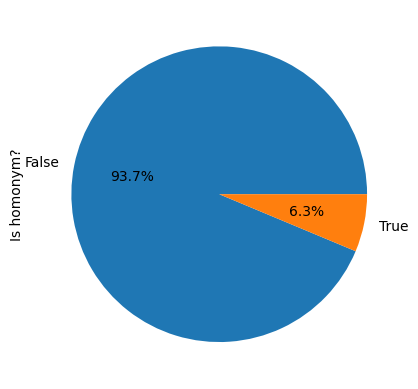

In [17]:
korean_company_names.isin(homonyms['표층형']).value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%', ylabel='Is homonym?')

### A distribution of lengths of the homonymous company names

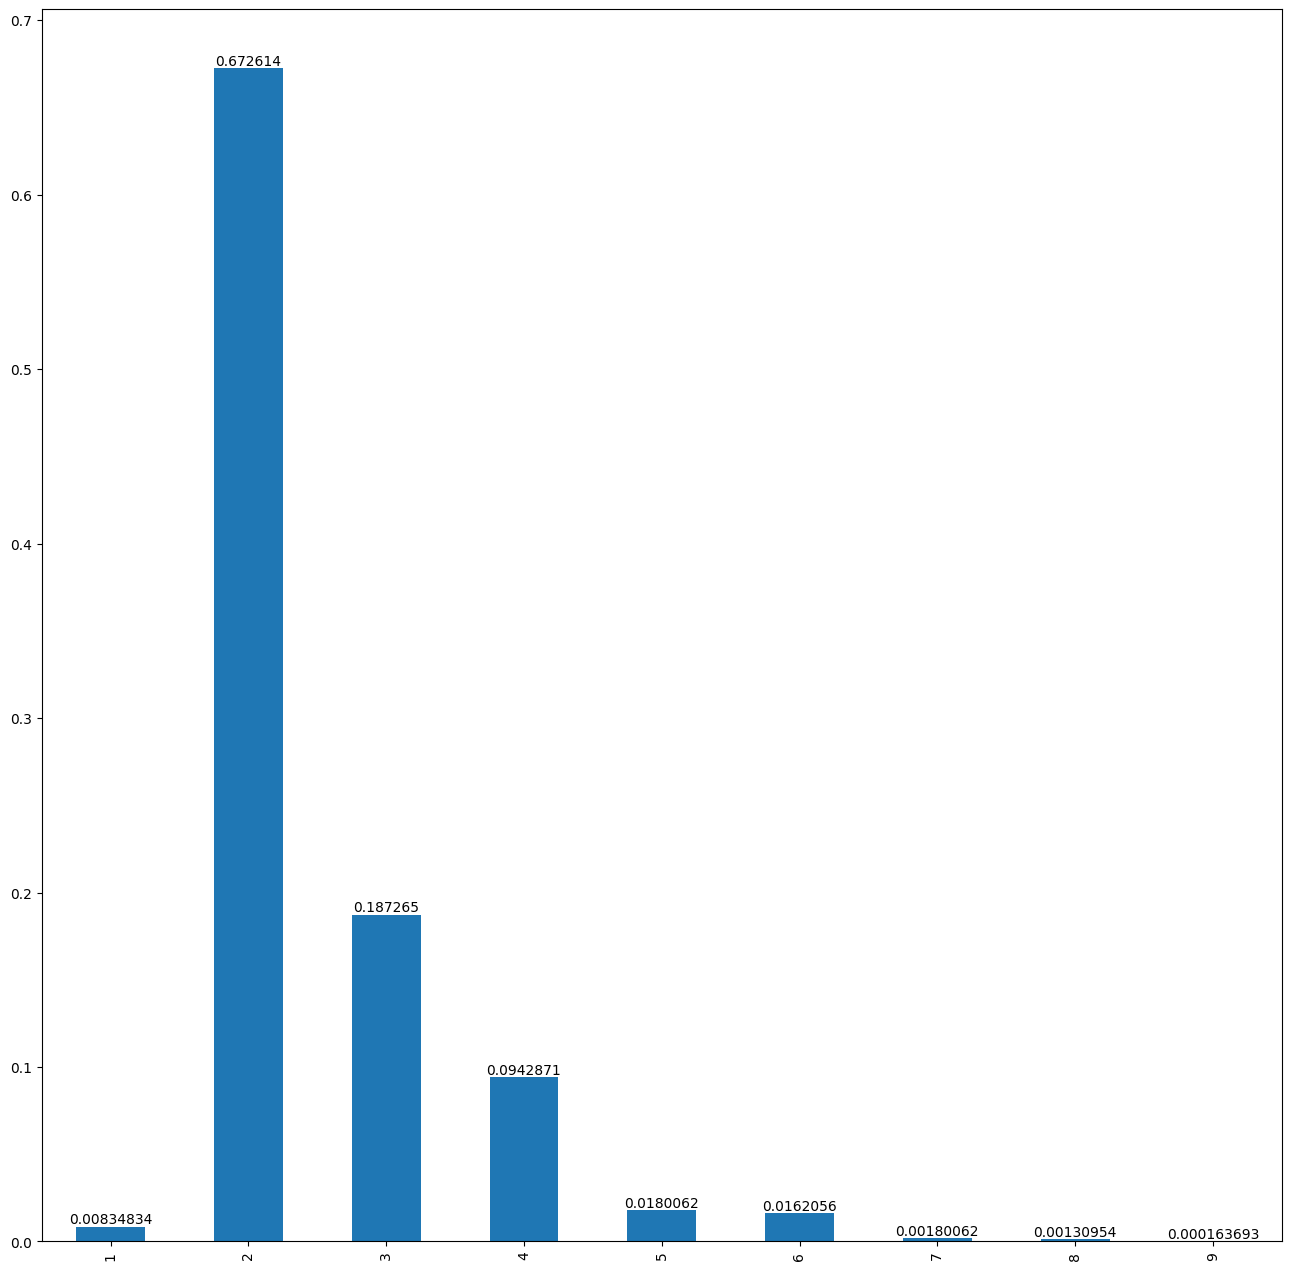

In [18]:
ax = korean_company_names[korean_company_names.isin(homonyms['표층형'])].str.len().value_counts(
    normalize=True, sort=False).sort_index().plot(kind='bar', figsize=(16, 16))
res = ax.bar_label(ax.containers[0])

### A distribution of lengths of the non-homonymous company names

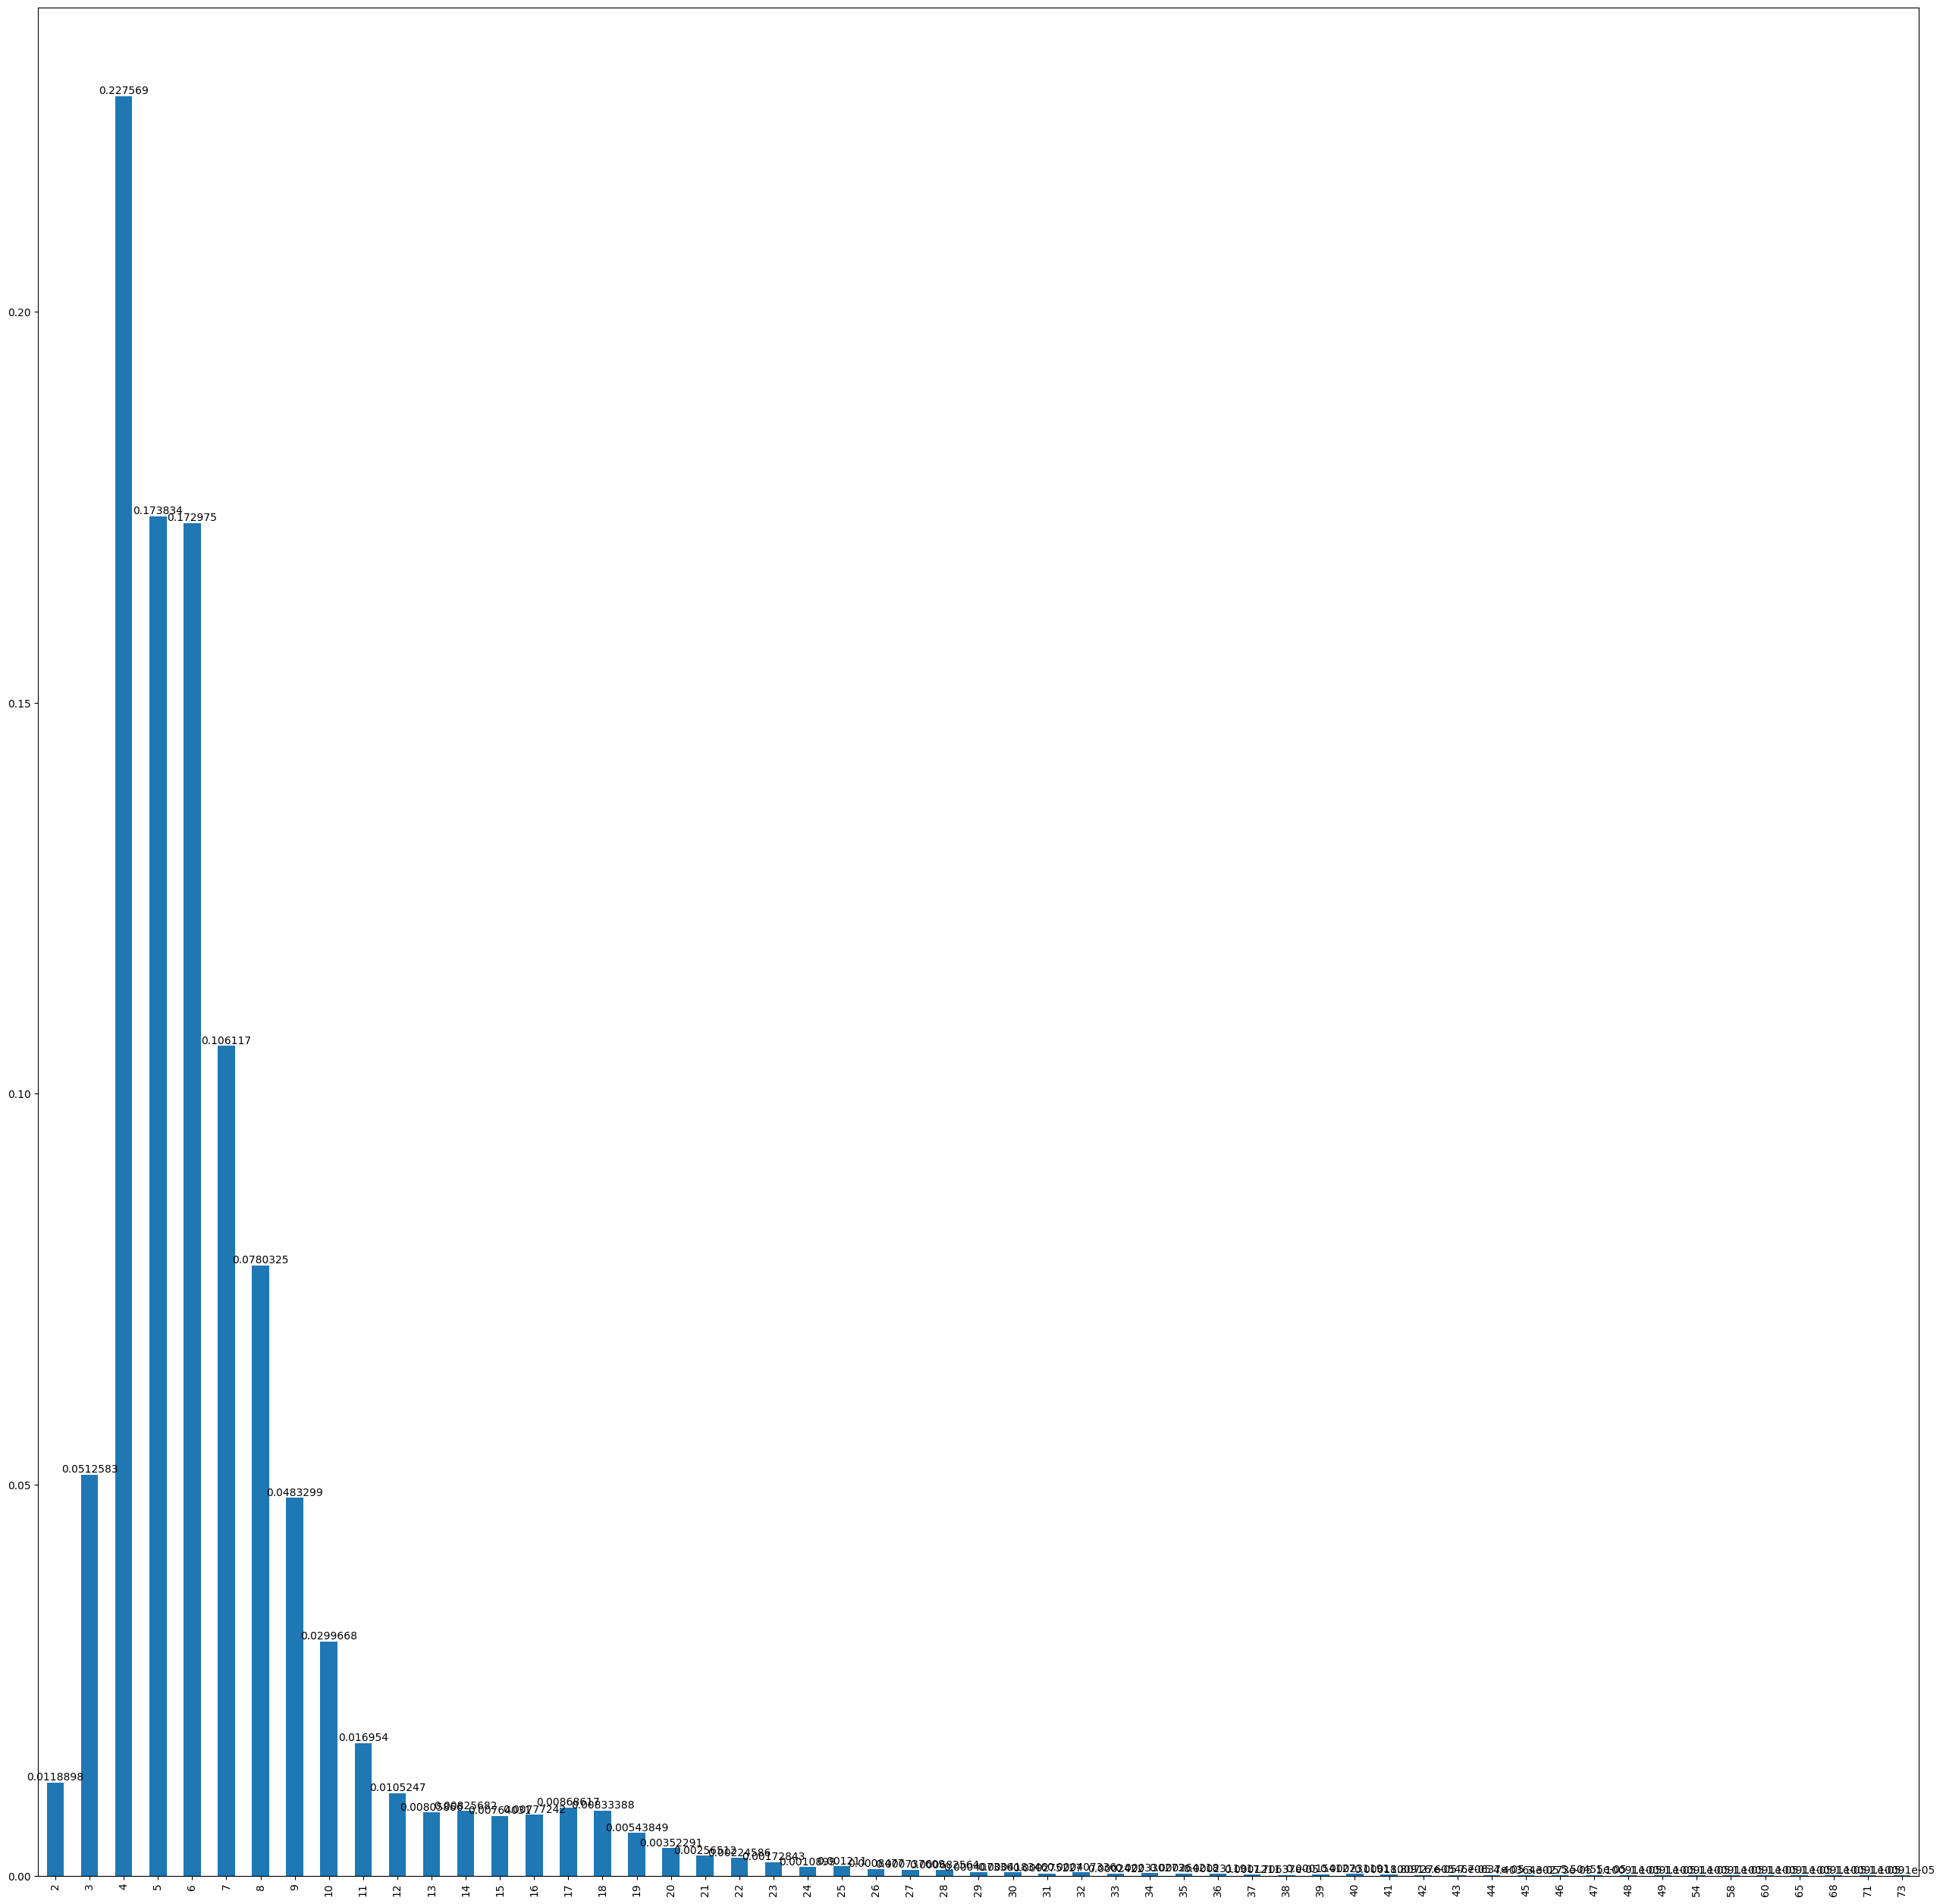

In [22]:
ax = korean_company_names[~korean_company_names.isin(homonyms['표층형'])].str.len().value_counts(
    normalize=True, sort=False).sort_index().plot(kind='bar', figsize=(32, 32))
res = ax.bar_label(ax.containers[0])

### A distribution of `품사` (Part-Of-Speech, POS) of the homonymous company names

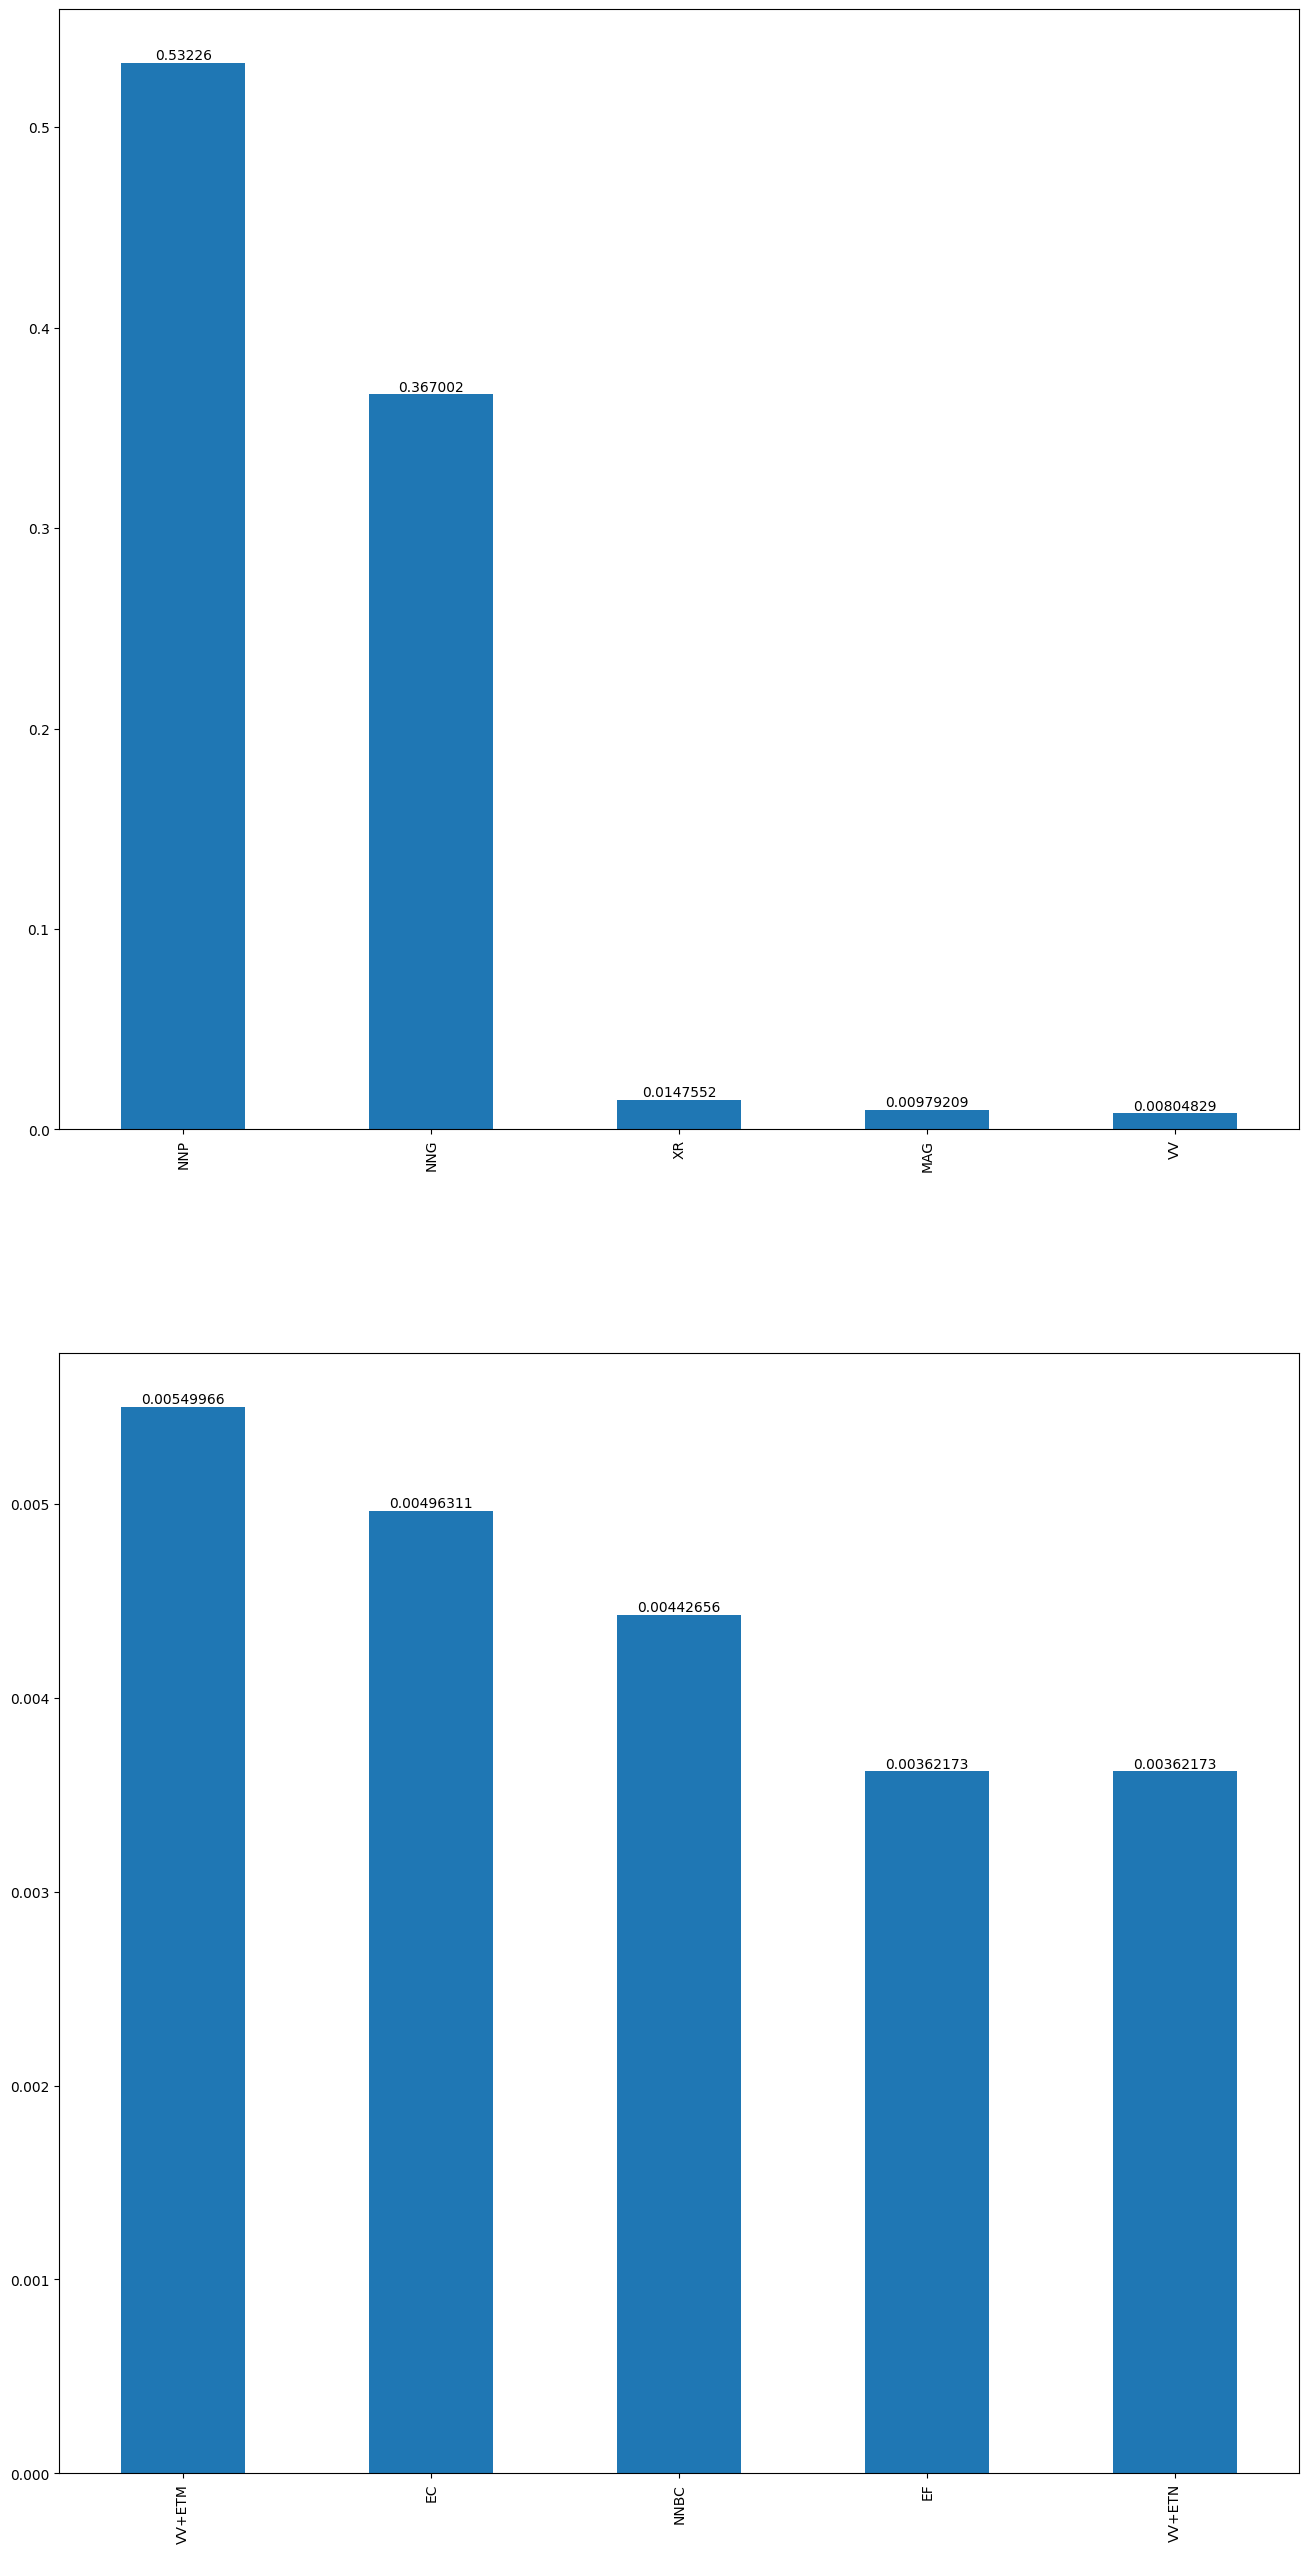

In [19]:
barchart_group_size = 5
num_images = 2 # math.ceil(homonyms['품사'].unique().shape[0]/barchart_group_size)

fig, axs = plt.subplots(num_images)

for idx in range(num_images):
    head_idx = barchart_group_size * idx
    tail_idx = head_idx + barchart_group_size
    ax = homonyms['품사'].value_counts(normalize=True)[head_idx:tail_idx].plot(figsize=(16, 32), kind='bar', ax=axs[idx])
    res = ax.bar_label(ax.containers[0])

### Examples of the homonymous company names which don't belong to NNP or NNG

In [37]:
non_proper_common_nouns = homonyms[~homonyms['품사'].isin(['NNP', 'NNG'])].groupby('품사')

In [43]:
for name, group in non_proper_common_nouns:
    display(group[:10])

,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
777310,고도,2,3,2039,EC,*,F,고도,*,*,*,*,EC.csv
777315,고려,2,3,2014,EC,*,F,고려,*,*,*,*,EC.csv
777323,고선,2,4,2151,EC,*,T,고선,*,*,*,*,EC.csv
777400,기로,2,3,4246,EC,*,F,기로,*,*,*,*,EC.csv
777408,길,2,4,4879,EC,*,T,길,*,*,*,*,EC.csv
777782,다라니,2,3,2124,EC,*,F,다라니,*,*,*,*,EC.csv
777811,다우,2,3,2197,EC,*,F,다우,*,*,*,*,EC.csv
777859,대우,2,3,2858,EC,*,F,대우,*,*,*,*,EC.csv
777860,대유,2,3,2159,EC,*,F,대유,*,*,*,*,EC.csv
777862,대지,2,3,2084,EC,*,F,대지,*,*,*,*,EC.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
81589,진,2,10,6062,EC+ETM,*,T,진,Inflect,EC,ETM,지/EC/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
49253,길,2,623,5149,EC+JKO,*,T,길,Inflect,EC,JKO,기/EC/*+ᆯ/JKO/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
47052,고도,2,1259,3491,EC+JX,*,F,고도,Inflect,EC,JX,라고/EC/*+도/JX/*,Inflect.csv
47116,고선,2,1759,791,EC+JX,*,T,고선,Inflect,EC,JX,고서/EC/*+ᆫ/JX/*,Inflect.csv
77146,은진,2,2378,2813,EC+JX,*,T,은진,Inflect,EC,JX,은지/EC/*+ㄴ/JX/*,Inflect.csv
81590,진,2,2502,3773,EC+JX,*,T,진,Inflect,EC,JX,지/EC/*+ㄴ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
64308,바른,2,10,669,EC+VA+ETM,*,T,바른,Inflect,EC,ETM,아/EC/*+바르/VA/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
62516,모아,2,3,2687,EC+VV+EC,*,F,모아,Inflect,EC,EC,아/EC/*+모으/VV/*+아/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
60647,래도,2,5,3302,EC+VV+EF,*,F,래도,Inflect,EC,EF,라/EC/*+하/VV/*+아도/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
64309,바른,2,10,3397,EC+VV+ETM,*,T,바른,Inflect,EC,ETM,아/EC/*+바르/VV/*+ᆫ/ETM/*,Inflect.csv
75473,오른,2,10,3434,EC+VV+ETM,*,T,오른,Inflect,EC,ETM,아/EC/*+오르/VV/*+ᆫ/ETM/*,Inflect.csv
75538,온,2,10,4679,EC+VV+ETM,*,T,온,Inflect,EC,ETM,아/EC/*+오/VV/*+ᆫ/ETM/*,Inflect.csv
80441,준,2,10,4014,EC+VV+ETM,*,T,준,Inflect,EC,ETM,아/EC/*+주/VV/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
60596,라온,2,10,2843,EC+VX+ETM,*,T,라온,Inflect,EC,ETM,아/EC/*+오/VX/*+ᆫ/ETM/*,Inflect.csv
75539,온,2,10,3796,EC+VX+ETM,*,T,온,Inflect,EC,ETM,아/EC/*+오/VX/*+ᆫ/ETM/*,Inflect.csv
80442,준,2,10,2617,EC+VX+ETM,*,T,준,Inflect,EC,ETM,아/EC/*+주/VX/*+ᆫ/ETM/*,Inflect.csv
81591,진,2,10,4347,EC+VX+ETM,*,T,진,Inflect,EC,ETM,어/EC/*+지/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
644362,나래,3,5,3990,EF,*,F,나래,*,*,*,*,EF.csv
644609,니오,3,5,4025,EF,*,F,니오,*,*,*,*,EF.csv
644710,다우,3,5,4033,EF,*,F,다우,*,*,*,*,EF.csv
644773,대유,3,5,4023,EF,*,F,대유,*,*,*,*,EF.csv
644776,대지,3,5,3874,EF,*,F,대지,*,*,*,*,EF.csv
644905,두나,3,5,4049,EF,*,F,두나,*,*,*,*,EF.csv
644906,두만,3,6,4109,EF,*,T,두만,*,*,*,*,EF.csv
644971,디오,3,5,4759,EF,*,F,디오,*,*,*,*,EF.csv
645034,라도,3,5,4723,EF,*,F,라도,*,*,*,*,EF.csv
645062,라지,3,5,4802,EF,*,F,라지,*,*,*,*,EF.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
69745,서서,4,3,4035,EP+EC,*,F,서서,Inflect,EP,EC,시/EP/*+어서/EC/*,Inflect.csv
70123,세유,4,3,2895,EP+EC,*,F,세유,Inflect,EP,EC,시/EP/*+어유/EC/*,Inflect.csv
71415,신지,4,3,4197,EP+EC,*,F,신지,Inflect,EP,EC,시/EP/*+ᆫ지/EC/*,Inflect.csv
78382,자,4,3,5764,EP+EC,*,F,자,Inflect,EP,EC,시/EP/*+자/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
70124,세유,4,5,2565,EP+EF,*,F,세유,Inflect,EP,EF,시/EP/*+어유/EF/*,Inflect.csv
71416,신지,4,5,3738,EP+EF,*,F,신지,Inflect,EP,EF,시/EP/*+ᆫ지/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
75525,오신,4,10,2051,EP+ETM,*,T,오신,Inflect,EP,ETM,옵시/EP/*+ᆫ/ETM/*,Inflect.csv
75540,온,4,10,4166,EP+ETM,*,T,온,Inflect,EP,ETM,오/EP/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
99247,온,148,10,3772,ETM,*,T,온,*,*,*,*,ETM.csv
99262,은,163,10,1501,ETM,*,T,은,*,*,*,*,ETM.csv
99274,인,176,10,4899,ETM,*,T,인,*,*,*,*,ETM.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
70454,수,128,2711,7225,ETM+NNB,*,F,수,Inflect,ETM,NNB,ᆯ/ETM/*+수/NNB/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77345,이도,172,1611,3662,ETM+NNB+JX,*,F,이도,Inflect,ETM,JX,ᆯ/ETM/*+이/NNB/*+도/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
645966,은,195,12,5308,ETN,*,T,은,*,*,*,*,ETN.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
49254,길,195,10,4384,ETN+ETM,*,T,길,Inflect,ETN,ETM,기/ETN/*+ᆯ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
49255,길,195,623,2599,ETN+JKO,*,T,길,Inflect,ETN,JKO,기/ETN/*+ᆯ/JKO/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
646336,구구,196,14,4686,IC,*,F,구구,*,*,*,*,IC.csv
646371,그리고,196,14,4516,IC,*,F,그리고,*,*,*,*,IC.csv
646411,나원,196,15,4622,IC,*,T,나원,*,*,*,*,IC.csv
646573,씨이,196,14,4500,IC,*,F,씨이,*,*,*,*,IC.csv
646623,아싸,196,14,4410,IC,*,F,아싸,*,*,*,*,IC.csv
646673,아이아,196,14,4510,IC,*,F,아이아,*,*,*,*,IC.csv
646691,아크,196,14,4453,IC,*,F,아크,*,*,*,*,IC.csv
646692,아하,196,14,4401,IC,*,F,아하,*,*,*,*,IC.csv
646936,에이치,196,14,4380,IC,*,F,에이치,*,*,*,*,IC.csv
647003,예스,196,14,4958,IC,*,F,예스,*,*,*,*,IC.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
644046,이다,234,64,4235,JC,*,F,이다,*,*,*,*,J.csv
644047,이든,235,90,4600,JC,*,T,이든,*,*,*,*,J.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
643926,보담,341,441,1963,JKB,*,T,보담,*,*,*,*,J.csv
644048,이든,417,454,4043,JKB,*,T,이든,*,*,*,*,J.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
644000,울,472,869,4501,JKO,*,T,울,*,*,*,*,J.csv
644017,은,474,875,5045,JKO,*,T,은,*,*,*,*,J.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
644018,은,520,1208,5112,JKS,*,T,은,*,*,*,*,J.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
60558,라도,504,3,3012,JKS+EC,*,F,라도,Inflect,JKS,EC,이/JKS/*+라도/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
71417,신지,511,3,1481,JKS+EP+EC,*,F,신지,Inflect,JKS,EC,이/JKS/*+시/EP/*+ᆫ지/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77143,은,520,2377,5138,JKS+JX,*,T,은,Inflect,JKS,JX,이/JKS/*+은/JX/*,Inflect.csv
77776,인,525,2415,5593,JKS+JX,*,T,인,Inflect,JKS,JX,이/JKS/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
643847,라도,609,1404,2280,JX,*,F,라도,*,*,*,*,J.csv
643862,래도,617,1410,2980,JX,*,F,래도,*,*,*,*,J.csv
643939,삼아,661,1501,3137,JX,*,F,삼아,*,*,*,*,J.csv
644001,유,678,1598,5319,JX,*,F,유,*,*,*,*,J.csv
644019,은,682,2377,349,JX,*,T,은,*,*,*,*,J.csv
644034,이건,688,2388,2975,JX,*,T,이건,*,*,*,*,J.csv
644049,이든,693,2391,3714,JX,*,T,이든,*,*,*,*,J.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77144,은,682,2377,6869,JX+JX,*,T,은,Inflect,JX,JX,은/JX/*+커녕/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77777,인,709,10,5498,JX+VCP+ETM,*,T,인,Inflect,JX,ETM,는/JX/*+이/VCP/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
300,강동,726,2634,4054,MAG,*,T,강동,*,*,*,*,MAG.csv
728,고리,726,2633,4265,MAG,*,F,고리,*,*,*,*,MAG.csv
1042,구구,726,2633,4340,MAG,*,F,구구,*,*,*,*,MAG.csv
1539,기연,726,2634,4092,MAG,*,T,기연,*,*,*,*,MAG.csv
1581,길,726,2634,6255,MAG,*,T,길,*,*,*,*,MAG.csv
1891,꼬끼오,735,2649,3337,MAG,성분부사|양태부사,F,꼬끼오,*,*,*,*,MAG.csv
2262,나리,726,2633,4178,MAG,*,F,나리,*,*,*,*,MAG.csv
2284,나우,726,2633,4357,MAG,*,F,나우,*,*,*,*,MAG.csv
2733,다다,726,2633,5262,MAG,*,F,다다,*,*,*,*,MAG.csv
2813,다함께,726,2633,4320,MAG,*,F,다함께,*,*,*,*,MAG.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77722,이젠,726,2414,852,MAG+JX,*,T,이젠,Inflect,MAG,JX,이제/MAG/*+ㄴ/JX/*,Inflect.csv
77868,인젠,726,2418,948,MAG+JX,*,T,인젠,Inflect,MAG,JX,인제/MAG/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
48088,그래도,726,3,639,MAG+XSV+EC,*,F,그래도,Inflect,MAG,EC,그리/MAG/*+하/XSV/*+어도/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
48089,그래도,726,5,1744,MAG+XSV+EF,*,F,그래도,Inflect,MAG,EF,그리/MAG/*+하/XSV/*+아도/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
647696,그래도,739,2655,850,MAJ,*,F,그래도,*,*,*,*,MAJ.csv
647765,그리고,739,2655,-983,MAJ,*,F,그리고,*,*,*,*,MAJ.csv
647887,하나,739,2655,3883,MAJ,*,F,하나,*,*,*,*,MAJ.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
311451,경,754,2676,7311,MM,~의존가산명사,T,경,*,*,*,*,MM.csv
311589,모든,746,2667,1457,MM,~명사,T,모든,*,*,*,*,MM.csv
311604,바른,746,2667,5823,MM,~명사,T,바른,*,*,*,*,MM.csv
311636,석,754,2676,4371,MM,~의존가산명사,T,석,*,*,*,*,MM.csv
311647,수,754,2675,5316,MM,~의존가산명사,F,수,*,*,*,*,MM.csv
311678,아모,746,2666,4765,MM,~명사,F,아모,*,*,*,*,MM.csv
311760,오륙,741,2660,5983,MM,~가산명사,T,오륙,*,*,*,*,MM.csv
311761,오른,746,2667,5460,MM,~명사,T,오른,*,*,*,*,MM.csv
311766,온,746,2667,4778,MM,~명사,T,온,*,*,*,*,MM.csv
311785,울,746,2667,8350,MM,~명사,T,울,*,*,*,*,MM.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
647920,경,827,2759,5864,NNB,*,T,경,*,*,*,*,NNB.csv
647923,길,832,2763,5329,NNB,*,T,길,*,*,*,*,NNB.csv
647930,나름,845,2769,1367,NNB,*,T,나름,*,*,*,*,NNB.csv
647983,생,920,2818,4248,NNB,*,T,생,*,*,*,*,NNB.csv
647986,수,923,2711,4899,NNB,*,F,수,*,*,*,*,NNB.csv
647999,이래,952,2724,2566,NNB,*,F,이래,*,*,*,*,NNB.csv
648006,자,961,2729,4313,NNB,*,F,자,*,*,*,*,NNB.csv
648011,정도,969,2731,3015,NNB,*,F,정도,*,*,*,*,NNB.csv
648018,지경,982,2837,1971,NNB,*,T,지경,*,*,*,*,NNB.csv
648035,터,1004,2744,5049,NNB,*,F,터,*,*,*,*,NNB.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77778,인,958,2415,5153,NNB+JX,*,T,인,Inflect,NNB,JX,이/NNB/*+ᆫ/JX/*,Inflect.csv
81592,진,983,2502,4892,NNB+JX,*,T,진,Inflect,NNB,JX,지/NNB/*+ㄴ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
71418,신지,930,3,1464,NNB+VCP+EC,*,F,신지,Inflect,NNB,EC,시/NNB/*+이/VCP/*+ᆫ지/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
89976,가우스,1045,2858,4589,NNBC,*,F,가우스,*,*,*,*,NNBC.csv
90005,경,1088,3234,7184,NNBC,*,T,경,*,*,*,*,NNBC.csv
90008,고리,1091,2872,4885,NNBC,*,F,고리,*,*,*,*,NNBC.csv
90061,길,1151,3262,5945,NNBC,*,T,길,*,*,*,*,NNBC.csv
90090,다스,1191,2915,4687,NNBC,*,F,다스,*,*,*,*,NNBC.csv
90091,다인,1192,3275,4724,NNBC,*,T,다인,*,*,*,*,NNBC.csv
90092,다임,1193,3276,4631,NNBC,*,T,다임,*,*,*,*,NNBC.csv
90143,디피에스,1246,2945,4589,NNBC,*,F,디피에스,*,*,*,*,NNBC.csv
90147,랜드,1250,2948,5072,NNBC,*,F,랜드,*,*,*,*,NNBC.csv
90158,로드,1261,2954,4755,NNBC,*,F,로드,*,*,*,*,NNBC.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
54722,다린,1189,1930,558,NNBC+JX,*,T,다린,Inflect,NNBC,JX,다리/NNBC/*+ㄴ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
55559,대중,1780,567,3917,NNG+JKG,*,T,대중,Inflect,NNG,JKG,대중/NNG/*+의/JKG/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
68947,사일,1780,781,3722,NNG+JKO,*,T,사일,Inflect,NNG,JKO,사이/NNG/*+ᆯ/JKO/*,Inflect.csv
70877,스파클,1780,802,2864,NNG+JKO,*,T,스파클,Inflect,NNG,JKO,스파크/NNG/*+ᆯ/JKO/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
46892,경운,1780,1751,1962,NNG+JX,*,T,경운,Inflect,NNG,JX,경우/NNG/*+ㄴ/JX/*,Inflect.csv
51415,나인,1780,1851,2557,NNG+JX,*,T,나인,Inflect,NNG,JX,나이/NNG/*+ᆫ/JX/*,Inflect.csv
61959,머린,1780,2051,2093,NNG+JX,*,T,머린,Inflect,NNG,JX,머리/NNG/*+ㄴ/JX/*,Inflect.csv
70232,소린,1780,2179,1647,NNG+JX,*,T,소린,Inflect,NNG,JX,소리/NNG/*+ᆫ/JX/*,Inflect.csv
77723,이젠,1780,2414,-292,NNG+JX,*,T,이젠,Inflect,NNG,JX,이제/NNG/*+ᆫ/JX/*,Inflect.csv
77869,인젠,1780,2418,1790,NNG+JX,*,T,인젠,Inflect,NNG,JX,인제/NNG/*+ᆫ/JX/*,Inflect.csv
80358,주진,1780,2483,2123,NNG+JX,*,T,주진,Inflect,NNG,JX,주지/NNG/*+ᆫ/JX/*,Inflect.csv
83763,친구,1780,1681,3055,NNG+JX,*,F,친구,Inflect,NNG,JX,친구/NNG/*+는/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
51416,나인,1780,10,3005,NNG+VCP+ETM,*,T,나인,Inflect,NNG,ETM,나이/NNG/*+이/VCP/*+ㄴ/ETM/*,Inflect.csv
64988,밴,1780,10,2569,NNG+VCP+ETM,*,T,밴,Inflect,NNG,ETM,배/NNG/*+이/VCP/*+ㄴ/ETM/*,Inflect.csv
68948,사일,1780,10,3255,NNG+VCP+ETM,*,T,사일,Inflect,NNG,ETM,사이/NNG/*+이/VCP/*+ᆯ/ETM/*,Inflect.csv
70055,세울,1780,10,2250,NNG+VCP+ETM,*,T,세울,Inflect,NNG,ETM,세우/NNG/*+이/VCP/*+ㄹ/ETM/*,Inflect.csv
70233,소린,1780,10,2378,NNG+VCP+ETM,*,T,소린,Inflect,NNG,ETM,소리/NNG/*+이/VCP/*+ㄴ/ETM/*,Inflect.csv
77779,인,1780,10,6094,NNG+VCP+ETM,*,T,인,Inflect,NNG,ETM,점/NNG/*+이/VCP/*+ᆫ/ETM/*,Inflect.csv
80272,주산,1780,10,2477,NNG+VCP+ETM,*,T,주산,Inflect,NNG,ETM,주사/NNG/*+이/VCP/*+ㄴ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77780,인,1780,3770,5984,NNG+XSN,*,T,인,Inflect,NNG,XSN,인정상/NNG/*+적/XSN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
76854,원준,1786,2362,1852,NNP+JX,*,T,원준,Inflect,NNP,JX,원주/NNP/지명+ᆫ/JX/*,Inflect.csv
77657,이스턴,1786,2410,1852,NNP+JX,*,T,이스턴,Inflect,NNP,JX,이스터/NNP/지명+ᆫ/JX/*,Inflect.csv
85483,평산,1786,2556,1852,NNP+JX,*,T,평산,Inflect,NNP,JX,평사/NNP/지명+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
76516,우린,1790,3555,3783,NP,*,T,우린,Inflect,NP,NP,우리/NP/*,Inflect.csv
76609,울,1790,3555,5408,NP,*,T,울,Inflect,NP,NP,우리/NP/*,Inflect.csv
645984,경,1790,3555,6543,NP,*,T,경,*,*,*,*,NP.csv
646122,선훈,1790,3555,3646,NP,*,T,선훈,*,*,*,*,NP.csv
646194,우리,1790,3554,164,NP,*,F,우리,*,*,*,*,NP.csv
646198,울,1790,3555,5408,NP,*,T,울,*,*,*,*,NP.csv
646226,이손,1790,3555,3827,NP,*,T,이손,*,*,*,*,NP.csv
646236,자,1790,3554,7088,NP,*,F,자,*,*,*,*,NP.csv
646278,정도,1790,3554,3784,NP,*,F,정도,*,*,*,*,NP.csv
646305,친구,1790,3554,5607,NP,*,F,친구,*,*,*,*,NP.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
75369,예서,1790,326,1539,NP+JKB,*,F,예서,Inflect,NP,JKB,여기/NP/*+서/JKB/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
76517,우린,1790,2357,-752,NP+JX,*,T,우린,Inflect,NP,JX,우리/NP/*+ㄴ/JX/*,Inflect.csv
77254,이건,1790,2388,-540,NP+JX,*,T,이건,Inflect,NP,JX,이거/NP/*+ㄴ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77255,이건,1790,10,2699,NP+VCP+ETM,*,T,이건,Inflect,NP,ETM,이것/NP/*+이/VCP/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
89489,경,1791,3557,6058,NR,*,T,경,*,*,*,*,NR.csv
89511,나인,1791,3557,3283,NR,*,T,나인,*,*,*,*,NR.csv
89804,오륙,1791,3557,3177,NR,*,T,오륙,*,*,*,*,NR.csv
89826,원,1791,3557,6171,NR,*,T,원,*,*,*,*,NR.csv
89827,유,1791,3556,6711,NR,*,F,유,*,*,*,*,NR.csv
89850,이삼,1791,3557,3790,NR,*,T,이삼,*,*,*,*,NR.csv
89874,이조,1791,3556,4066,NR,*,F,이조,*,*,*,*,NR.csv
89888,일만,1791,3557,2952,NR,*,T,일만,*,*,*,*,NR.csv
89896,일이,1791,3556,5147,NR,*,F,일이,*,*,*,*,NR.csv
89904,일천,1791,3557,1941,NR,*,T,일천,*,*,*,*,NR.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
57555,두리,1791,1097,878,NR+JKS,*,F,두리,Inflect,NR,JKS,둘/NR/*+이/JKS/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
84996,파라,1804,3571,4534,VA,*,F,파라,Inflect,VA,VA,파랗/VA/*,Inflect.csv
442511,건하,1804,3571,4140,VA,*,F,건하,*,*,*,*,VA.csv
442565,고리,1804,3571,4245,VA,*,F,고리,*,*,*,*,VA.csv
442760,길,1804,3572,4130,VA,*,T,길,*,*,*,*,VA.csv
443157,마디,1804,3571,4952,VA,*,F,마디,*,*,*,*,VA.csv
443170,만나,1804,3571,4014,VA,*,F,만나,*,*,*,*,VA.csv
443242,모나,1804,3571,4281,VA,*,F,모나,*,*,*,*,VA.csv
443576,상하,1804,3571,4280,VA,*,F,상하,*,*,*,*,VA.csv
443648,성하,1804,3571,3835,VA,*,F,성하,*,*,*,*,VA.csv
443737,시리,1804,3571,4529,VA,*,F,시리,*,*,*,*,VA.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
48090,그래도,1804,3,1495,VA+EC,*,F,그래도,Inflect,VA,EC,그렇/VA/*+어도/EC/*,Inflect.csv
77351,이래,1804,3,2534,VA+EC,*,F,이래,Inflect,VA,EC,이렇/VA/*+어/EC/*,Inflect.csv
77456,이레,1804,3,1685,VA+EC,*,F,이레,Inflect,VA,EC,이렇/VA/*+어/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
51427,나진,1804,10,934,VA+EC+VX+ETM,*,T,나진,Inflect,VA,ETM,낫/VA/*+ㅏ/EC/*+지/VX/*+ㄴ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77352,이래,1804,5,3188,VA+EF,*,F,이래,Inflect,VA,EF,이렇/VA/*+ㅕ/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
47153,고운,1804,10,279,VA+ETM,*,T,고운,Inflect,VA,ETM,곱/VA/*+ᆫ/ETM/*,Inflect.csv
47162,고은,1804,10,1078,VA+ETM,*,T,고은,Inflect,VA,ETM,곱/VA/*+ᆫ/ETM/*,Inflect.csv
49256,길,1804,10,3343,VA+ETM,*,T,길,Inflect,VA,ETM,길/VA/*+ᆯ/ETM/*,Inflect.csv
51407,나은,1804,10,1921,VA+ETM,*,T,나은,Inflect,VA,ETM,낫/VA/*+ᆫ/ETM/*,Inflect.csv
55561,대찬,1804,10,915,VA+ETM,*,T,대찬,Inflect,VA,ETM,대차/VA/*+ᆫ/ETM/*,Inflect.csv
55802,더한,1804,10,967,VA+ETM,*,T,더한,Inflect,VA,ETM,더하/VA/*+ᆫ/ETM/*,Inflect.csv
64310,바른,1804,10,-108,VA+ETM,*,T,바른,Inflect,VA,ETM,바르/VA/*+ᆫ/ETM/*,Inflect.csv
64989,밴,1804,10,1273,VA+ETM,*,T,밴,Inflect,VA,ETM,배/VA/*+ᆫ/ETM/*,Inflect.csv
65840,보람찬,1804,10,915,VA+ETM,*,T,보람찬,Inflect,VA,ETM,보람차/VA/*+ᆫ/ETM/*,Inflect.csv
69860,선한,1804,10,1361,VA+ETM,*,T,선한,Inflect,VA,ETM,선하/VA/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
55810,더함,1804,12,2507,VA+ETN,*,T,더함,Inflect,VA,ETN,더하/VA/*+ᄆ/ETN/*,Inflect.csv
72813,아름다움,1804,12,-67,VA+ETN,*,T,아름다움,Inflect,VA,ETN,아름답/VA/*+ᄆ/ETN/*,Inflect.csv
85533,푸름,1804,12,1715,VA+ETN,*,T,푸름,Inflect,VA,ETN,푸르/VA/*+ᄆ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
72814,아름다움,1804,447,432,VA+ETN+JKB,*,T,아름다움,Inflect,VA,JKB,아름답/VA/*+ᄆ/ETN/*+에서/JKB/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77781,인,2240,3576,6322,VCP,*,T,인,Inflect,VCP,VCP,이/VCP/*,Inflect.csv
99150,터,2416,3575,5564,VCP,*,F,터,*,*,*,*,VCP.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
47053,고도,1828,3,2328,VCP+EC,*,F,고도,Inflect,VCP,EC,이/VCP/*+고도/EC/*,Inflect.csv
60559,라도,2017,3,211,VCP+EC,*,F,라도,Inflect,VCP,EC,이/VCP/*+라도/EC/*,Inflect.csv
60602,라지,2041,3,2617,VCP+EC,*,F,라지,Inflect,VCP,EC,이/VCP/*+라지/EC/*,Inflect.csv
60648,래도,2069,3,2853,VCP+EC,*,F,래도,Inflect,VCP,EC,이/VCP/*+래도/EC/*,Inflect.csv
76979,유,2234,3,4919,VCP+EC,*,F,유,Inflect,VCP,EC,이/VCP/*+유/EC/*,Inflect.csv
77782,인,2240,4,5615,VCP+EC,*,T,인,Inflect,VCP,EC,이/VCP/*+ᆫ가/EC/*,Inflect.csv
78383,자,2387,3,4391,VCP+EC,*,F,자,Inflect,VCP,EC,이/VCP/*+자/EC/*,Inflect.csv
81416,지이,2413,3,2733,VCP+EC,*,F,지이,Inflect,VCP,EC,이/VCP/*+지이/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77885,인진,2296,2421,1705,VCP+EC+JX,*,T,인진,Inflect,VCP,JX,이/VCP/*+ᆫ지/EC/*+ᆫ/JX/*,Inflect.csv
78161,일진,2341,2425,1725,VCP+EC+JX,*,T,일진,Inflect,VCP,JX,이/VCP/*+ㄹ지/EC/*+ㄴ/JX/*,Inflect.csv
81594,진,2414,2502,4782,VCP+EC+JX,*,T,진,Inflect,VCP,JX,이/VCP/*+지/EC/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
60560,라도,2017,5,3344,VCP+EF,*,F,라도,Inflect,VCP,EF,이/VCP/*+라도/EF/*,Inflect.csv
60603,라지,2041,5,3365,VCP+EF,*,F,라지,Inflect,VCP,EF,이/VCP/*+라지/EF/*,Inflect.csv
76980,유,2234,5,5529,VCP+EF,*,F,유,Inflect,VCP,EF,이/VCP/*+유/EF/*,Inflect.csv
77783,인,2240,6,5884,VCP+EF,*,T,인,Inflect,VCP,EF,이/VCP/*+ㄴ가/EF/*,Inflect.csv
81368,지유,2412,5,2590,VCP+EF,*,F,지유,Inflect,VCP,EF,이/VCP/*+지유/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
71419,신지,2149,3,2149,VCP+EP+EC,*,F,신지,Inflect,VCP,EC,이/VCP/*+시/EP/*+ᆫ지/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
70125,세유,2136,5,958,VCP+EP+EF,*,F,세유,Inflect,VCP,EF,이/VCP/*+시/EP/*+어유/EF/*,Inflect.csv
71420,신지,2149,5,1958,VCP+EP+EF,*,F,신지,Inflect,VCP,EF,이/VCP/*+시/EP/*+ᆫ지/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77145,은,2236,10,4180,VCP+ETM,*,T,은,Inflect,VCP,ETM,이/VCP/*+은/ETM/*,Inflect.csv
77784,인,2240,10,894,VCP+ETM,*,T,인,Inflect,VCP,ETM,이/VCP/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77867,인제,2288,360,2244,VCP+ETM+NNB+JKB,*,F,인제,Inflect,VCP,JKB,이/VCP/*+ᆫ/ETM/*+적/NNB/*+에/JKB/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77785,인,2240,2415,6193,VCP+JX,*,T,인,Inflect,VCP,JX,이/VCP/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
60561,라도,2017,3,3357,VCP+VCP+EC,*,F,라도,Inflect,VCP,EC,이/VCP/*+이/VCP/*+라도/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
49103,기우,2420,3577,4468,VV,*,F,기우,Inflect,VV,VV,기울/VV/*,Inflect.csv
49257,길,2420,3578,7604,VV,*,T,길,Inflect,VV,VV,긷/VV/*,Inflect.csv
62309,메인,2420,3578,4506,VV,*,T,메인,Inflect,VV,VV,메이/VV/*,Inflect.csv
67887,비트,2420,3577,4456,VV,*,F,비트,Inflect,VV,VV,비틀/VV/*,Inflect.csv
78384,자,2420,3577,5690,VV,*,F,자,Inflect,VV,VV,잣/VV/*,Inflect.csv
84502,터,2420,3577,7229,VV,*,F,터,Inflect,VV,VV,털/VV/*,Inflect.csv
90731,가보,2420,3577,7450,VV,*,F,가보,*,*,*,*,VV.csv
90744,가하,2420,3577,4295,VV,*,F,가하,*,*,*,*,VV.csv
91350,기우,2420,3577,4468,VV,*,F,기우,*,*,*,*,VV.csv
91364,길,2420,3578,7604,VV,*,T,길,*,*,*,*,VV.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
45107,가주,2420,3,1510,VV+EC,*,F,가주,Inflect,VV,EC,가지/VV/*+우/EC/*,Inflect.csv
48091,그래도,2420,3,-1301,VV+EC,*,F,그래도,Inflect,VV,EC,그러/VV/*+어도/EC/*,Inflect.csv
48562,그리고,2420,3,1330,VV+EC,*,F,그리고,Inflect,VV,EC,그리하/VV/*+고/EC/*,Inflect.csv
51506,난다,2420,3,1980,VV+EC,*,F,난다,Inflect,VV,EC,나/VV/*+ᆫ다/EC/*,Inflect.csv
55295,달해,2420,3,613,VV+EC,*,F,달해,Inflect,VV,EC,달하/VV/*+아/EC/*,Inflect.csv
55582,대해,2420,3,-179,VV+EC,*,F,대해,Inflect,VV,EC,대하/VV/*+아/EC/*,Inflect.csv
56774,동해,2420,3,1253,VV+EC,*,F,동해,Inflect,VV,EC,동하/VV/*+아/EC/*,Inflect.csv
61152,만나,2420,3,-752,VV+EC,*,F,만나,Inflect,VV,EC,만나/VV/*+아/EC/*,Inflect.csv
62517,모아,2420,3,-96,VV+EC,*,F,모아,Inflect,VV,EC,모으/VV/*+아/EC/*,Inflect.csv
64219,바라,2420,3,2982,VV+EC,*,F,바라,Inflect,VV,EC,바라/VV/*+아/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
55583,대해,2420,3575,4756,VV+EC+VCP,*,F,대해,Inflect,VV,VCP,대하/VV/*+아/EC/*+이/VCP/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86997,해드린,2420,10,1819,VV+EC+VX+ETM,*,T,해드린,Inflect,VV,ETM,하/VV/*+아/EC/*+드리/VX/*+ᆫ/ETM/*,Inflect.csv
87332,해온,2420,10,1666,VV+EC+VX+ETM,*,T,해온,Inflect,VV,ETM,하/VV/*+아/EC/*+오/VX/*+ᆫ/ETM/*,Inflect.csv
87342,해올,2420,10,2290,VV+EC+VX+ETM,*,T,해올,Inflect,VV,ETM,하/VV/*+아/EC/*+오/VX/*+ᆯ/ETM/*,Inflect.csv
87570,해진,2420,10,757,VV+EC+VX+ETM,*,T,해진,Inflect,VV,ETM,하/VV/*+아/EC/*+지/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87347,해옴,2420,12,1029,VV+EC+VX+ETN,*,T,해옴,Inflect,VV,ETN,하/VV/*+아/EC/*+오/VX/*+ᄆ/ETN/*,Inflect.csv
87515,해줌,2420,12,1033,VV+EC+VX+ETN,*,T,해줌,Inflect,VV,ETN,하/VV/*+아/EC/*+주/VX/*+ᄆ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
51507,난다,2420,5,1458,VV+EF,*,F,난다,Inflect,VV,EF,나/VV/*+ᆫ다/EF/*,Inflect.csv
54784,다우,2420,5,1888,VV+EF,*,F,다우,Inflect,VV,EF,달/VV/*+오/EF/*,Inflect.csv
55584,대해,2420,5,3197,VV+EF,*,F,대해,Inflect,VV,EF,대하/VV/*+아/EF/*,Inflect.csv
61153,만나,2420,5,1048,VV+EF,*,F,만나,Inflect,VV,EF,만나/VV/*+아/EF/*,Inflect.csv
62518,모아,2420,5,2191,VV+EF,*,F,모아,Inflect,VV,EF,모으/VV/*+아/EF/*,Inflect.csv
68073,빛나,2420,5,1589,VV+EF,*,F,빛나,Inflect,VV,EF,빛나/VV/*+아/EF/*,Inflect.csv
75542,온,2420,6,3945,VV+EF,*,T,온,Inflect,VV,EF,오/VV/*+ᆫ/EF/*,Inflect.csv
77354,이래,2420,5,2628,VV+EF,*,F,이래,Inflect,VV,EF,이러/VV/*+어/EF/*,Inflect.csv
78386,자,2420,5,4906,VV+EF,*,F,자,Inflect,VV,EF,자/VV/*+아/EF/*,Inflect.csv
79083,재우,2420,5,1482,VV+EF,*,F,재우,Inflect,VV,EF,재우/VV/*+우/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
70946,시고,2420,3,2453,VV+EP+EC,*,F,시고,Inflect,VV,EC,하/VV/*+시/EP/*+고/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
72950,아신,2420,10,1540,VV+EP+ETM,*,T,아신,Inflect,VV,ETM,알/VV/*+시/EP/*+ᆫ/ETM/*,Inflect.csv
76562,우신,2420,10,933,VV+EP+ETM,*,T,우신,Inflect,VV,ETM,울/VV/*+시/EP/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
48607,그린,2420,10,1247,VV+ETM,*,T,그린,Inflect,VV,ETM,그리/VV/*+ᆫ/ETM/*,Inflect.csv
49258,길,2420,10,3917,VV+ETM,*,T,길,Inflect,VV,ETM,기/VV/*+ᆯ/ETM/*,Inflect.csv
54723,다린,2420,10,1290,VV+ETM,*,T,다린,Inflect,VV,ETM,다리/VV/*+ᆫ/ETM/*,Inflect.csv
54740,다물,2420,10,703,VV+ETM,*,T,다물,Inflect,VV,ETM,다물/VV/*+ᆯ/ETM/*,Inflect.csv
55543,대본,2420,10,1431,VV+ETM,*,T,대본,Inflect,VV,ETM,대보/VV/*+ᆫ/ETM/*,Inflect.csv
55566,대한,2420,10,-849,VV+ETM,*,T,대한,Inflect,VV,ETM,대하/VV/*+ᆫ/ETM/*,Inflect.csv
55803,더한,2420,10,1136,VV+ETM,*,T,더한,Inflect,VV,ETM,더하/VV/*+ᆫ/ETM/*,Inflect.csv
56768,동인,2420,10,1757,VV+ETM,*,T,동인,Inflect,VV,ETM,동이/VV/*+ᆫ/ETM/*,Inflect.csv
58269,드림,2420,10,1111,VV+ETM,*,T,드림,Inflect,VV,ETM,드리/VV/*+ᆫ/ETM/*,Inflect.csv
62310,메인,2420,10,1739,VV+ETM,*,T,메인,Inflect,VV,ETM,메이/VV/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
85963,한건,2420,10,1630,VV+ETM+NNB+VCP+ETM,*,T,한건,Inflect,VV,ETM,하/VV/*+ᆫ/ETM/*+것/NNB/*+이/VCP/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
44900,가림,2420,12,3269,VV+ETN,*,T,가림,Inflect,VV,ETN,가리/VV/*+ᄆ/ETN/*,Inflect.csv
46058,거림,2420,12,3984,VV+ETN,*,T,거림,Inflect,VV,ETN,거리/VV/*+ᄆ/ETN/*,Inflect.csv
48628,그림,2420,12,3412,VV+ETN,*,T,그림,Inflect,VV,ETN,그리/VV/*+ᄆ/ETN/*,Inflect.csv
50236,꿈,2420,12,3342,VV+ETN,*,T,꿈,Inflect,VV,ETN,꾸/VV/*+ㅁ/ETN/*,Inflect.csv
50970,나눔,2420,12,2492,VV+ETN,*,T,나눔,Inflect,VV,ETN,나누/VV/*+ᄆ/ETN/*,Inflect.csv
54892,다함,2420,12,2811,VV+ETN,*,T,다함,Inflect,VV,ETN,다하/VV/*+ᄆ/ETN/*,Inflect.csv
55811,더함,2420,12,2707,VV+ETN,*,T,더함,Inflect,VV,ETN,더하/VV/*+ᄆ/ETN/*,Inflect.csv
56326,도움,2420,12,3820,VV+ETN,*,T,도움,Inflect,VV,ETN,돕/VV/*+ᄆ/ETN/*,Inflect.csv
57476,두드림,2420,12,2707,VV+ETN,*,T,두드림,Inflect,VV,ETN,두드리/VV/*+ᄆ/ETN/*,Inflect.csv
58270,드림,2420,12,2853,VV+ETN,*,T,드림,Inflect,VV,ETN,드리/VV/*+ᄆ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86862,해긴,2420,2595,-83,VV+ETN+JX,*,T,해긴,Inflect,VV,JX,하/VV/*+기/ETN/*+ㄴ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
75544,온,2420,2338,4840,VV+JX,*,T,온,Inflect,VV,JX,오/VV/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
48092,그래도,2420,2655,2322,VV+MAJ,*,F,그래도,Inflect,VV,MAJ,그러/VV/*+ㅕ도/MAJ/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
45108,가주,2421,3579,4955,VX,*,F,가주,Inflect,VX,VX,가지/VX/*,Inflect.csv
81596,진,2421,3580,8028,VX,*,T,진,Inflect,VX,VX,지/VX/*,Inflect.csv
447132,대하,2421,3579,4580,VX,*,F,대하,*,*,*,*,VX.csv
447157,바라,2421,3579,6351,VX,*,F,바라,*,*,*,*,VX.csv
447216,준,2421,3580,6514,VX,*,T,준,*,*,*,*,VX.csv
447220,진하,2421,3579,4625,VX,*,F,진하,*,*,*,*,VX.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
84997,파라,2421,3,3254,VX+EC,*,F,파라,Inflect,VX,EC,프/VX/*+아라/EC/*,Inflect.csv
86305,한들,2421,4,3885,VX+EC,*,T,한들,Inflect,VX,EC,하/VX/*+ᆫ들/EC/*,Inflect.csv
86950,해도,2421,3,1443,VX+EC,*,F,해도,Inflect,VX,EC,하/VX/*+아도/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86998,해드린,2421,10,3189,VX+EC+VX+ETM,*,T,해드린,Inflect,VX,ETM,하/VX/*+아/EC/*+드리/VX/*+ᆫ/ETM/*,Inflect.csv
87333,해온,2421,10,3217,VX+EC+VX+ETM,*,T,해온,Inflect,VX,ETM,하/VX/*+아/EC/*+오/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
51508,난다,2421,5,4063,VX+EF,*,F,난다,Inflect,VX,EF,나/VX/*+ᆫ다/EF/*,Inflect.csv
86235,한대,2421,5,3041,VX+EF,*,F,한대,Inflect,VX,EF,하/VX/*+ᆫ대/EF/*,Inflect.csv
86951,해도,2421,5,3381,VX+EF,*,F,해도,Inflect,VX,EF,하/VX/*+ㅕ도/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
75545,온,2421,10,2838,VX+ETM,*,T,온,Inflect,VX,ETM,오/VX/*+ᆫ/ETM/*,Inflect.csv
80444,준,2421,10,2028,VX+ETM,*,T,준,Inflect,VX,ETM,주/VX/*+ᆫ/ETM/*,Inflect.csv
81597,진,2421,10,3561,VX+ETM,*,T,진,Inflect,VX,ETM,지/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
85964,한건,2421,2571,2236,VX+ETM+NNB+JX,*,T,한건,Inflect,VX,JX,하/VX/*+ᆫ/ETM/*+것/NNB/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
311935,생,2422,3582,4524,XPN,*,T,생,*,*,*,*,XPN.csv
311947,온,2422,3582,7205,XPN,*,T,온,*,*,*,*,XPN.csv
311949,원,2422,3582,7496,XPN,*,T,원,*,*,*,*,XPN.csv
311950,유,2422,3581,8123,XPN,*,F,유,*,*,*,*,XPN.csv
311955,정,2422,3582,6945,XPN,*,T,정,*,*,*,*,XPN.csv
311959,준,2422,3582,4429,XPN,*,T,준,*,*,*,*,XPN.csv
311961,진,2422,3582,7874,XPN,*,T,진,*,*,*,*,XPN.csv
311973,통,2422,3582,7476,XPN,*,T,통,*,*,*,*,XPN.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
307840,가연,2423,3584,5406,XR,*,T,가연,*,*,*,*,XR.csv
307961,건강,2423,3584,4722,XR,*,T,건강,*,*,*,*,XR.csv
307993,경,2423,3584,7578,XR,*,T,경,*,*,*,*,XR.csv
308023,고명,2423,3584,4972,XR,*,T,고명,*,*,*,*,XR.csv
308091,광장,2423,3584,4871,XR,*,T,광장,*,*,*,*,XR.csv
308115,구구,2423,3583,5253,XR,*,F,구구,*,*,*,*,XR.csv
308144,국제,2423,3583,4640,XR,*,F,국제,*,*,*,*,XR.csv
308247,길,2423,3584,7038,XR,*,T,길,*,*,*,*,XR.csv
308431,남상,2423,3584,4982,XR,*,T,남상,*,*,*,*,XR.csv
308600,다스,2423,3583,5077,XR,*,F,다스,*,*,*,*,XR.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86306,한들,2424,4,2854,XSA+EC,*,T,한들,Inflect,XSA,EC,하/XSA/*+ᆫ들/EC/*,Inflect.csv
86952,해도,2424,3,421,XSA+EC,*,F,해도,Inflect,XSA,EC,하/XSA/*+아도/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87334,해온,2424,10,2933,XSA+EC+VX+ETM,*,T,해온,Inflect,XSA,ETM,하/XSA/*+아/EC/*+오/VX/*+ᆫ/ETM/*,Inflect.csv
87343,해올,2424,10,2689,XSA+EC+VX+ETM,*,T,해올,Inflect,XSA,ETM,하/XSA/*+아/EC/*+오/VX/*+ᆯ/ETM/*,Inflect.csv
87572,해진,2424,10,-392,XSA+EC+VX+ETM,*,T,해진,Inflect,XSA,ETM,하/XSA/*+아/EC/*+지/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87348,해옴,2424,12,407,XSA+EC+VX+ETN,*,T,해옴,Inflect,XSA,ETN,하/XSA/*+아/EC/*+오/VX/*+ᄆ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86236,한대,2424,5,3095,XSA+EF,*,F,한대,Inflect,XSA,EF,하/XSA/*+ᆫ대/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
54789,다운,2424,10,10,XSA+ETM,*,T,다운,Inflect,XSA,ETM,답/XSA/*+ᆫ/ETM/*,Inflect.csv
54796,다울,2424,10,1573,XSA+ETM,*,T,다울,Inflect,XSA,ETM,답/XSA/*+ᆯ/ETM/*,Inflect.csv
81598,진,2424,10,5101,XSA+ETM,*,T,진,Inflect,XSA,ETM,지/XSA/*+ㄴ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
54798,다움,2424,12,2241,XSA+ETN,*,T,다움,Inflect,XSA,ETN,답/XSA/*+ᄆ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87573,해진,2424,10,1899,XSA+XSA+EC+VX+ETM,*,T,해진,Inflect,XSA,ETM,하/XSA/*+하/XSA/*+아/EC/*+지/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
89373,경,2440,3677,4533,XSN,*,T,경,*,*,*,*,XSN.csv
89405,류,2507,3609,3559,XSN,*,F,류,*,*,*,*,XSN.csv
89425,생,2547,3743,2957,XSN,*,T,생,*,*,*,*,XSN.csv
89443,유,2587,3636,5972,XSN,*,F,유,*,*,*,*,XSN.csv
89446,인,2590,3770,4576,XSN,*,T,인,*,*,*,*,XSN.csv
89447,자,2593,3638,4780,XSN,*,F,자,*,*,*,*,XSN.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77787,인,2590,10,6451,XSN+ETM,*,T,인,Inflect,XSN,ETM,이/XSN/*+ㄴ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
77788,인,2590,2415,5475,XSN+JX,*,T,인,Inflect,XSN,JX,이/XSN/*+ㄴ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
311987,대하,2692,3820,5281,XSV,*,F,대하,*,*,*,*,XSV.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
84298,타가,2692,3,2120,XSV+EC,*,F,타가,Inflect,XSV,EC,하/XSV/*+다가/EC/*,Inflect.csv
86307,한들,2692,4,2582,XSV+EC,*,T,한들,Inflect,XSV,EC,하/XSV/*+ᆫ들/EC/*,Inflect.csv
86953,해도,2692,3,-350,XSV+EC,*,F,해도,Inflect,XSV,EC,하/XSV/*+아도/EC/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
81599,진,2692,2502,5981,XSV+EC+JX,*,T,진,Inflect,XSV,JX,하/XSV/*+지/EC/*+ᆫ/JX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87040,해마,2692,3579,4241,XSV+EC+VX,*,F,해마,Inflect,XSV,VX,하/XSV/*+아/EC/*+말/VX/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87335,해온,2692,10,2937,XSV+EC+VX+ETM,*,T,해온,Inflect,XSV,ETM,하/XSV/*+아/EC/*+오/VX/*+ᆫ/ETM/*,Inflect.csv
87344,해올,2692,10,3982,XSV+EC+VX+ETM,*,T,해올,Inflect,XSV,ETM,하/XSV/*+아/EC/*+오/VX/*+ᆯ/ETM/*,Inflect.csv
87574,해진,2692,10,2154,XSV+EC+VX+ETM,*,T,해진,Inflect,XSV,ETM,하/XSV/*+아/EC/*+지/VX/*+ᆫ/ETM/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
87349,해옴,2692,12,3072,XSV+EC+VX+ETN,*,T,해옴,Inflect,XSV,ETN,하/XSV/*+아/EC/*+오/VX/*+ᄆ/ETN/*,Inflect.csv
87516,해줌,2692,12,3185,XSV+EC+VX+ETN,*,T,해줌,Inflect,XSV,ETN,하/XSV/*+아/EC/*+주/VX/*+ᄆ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86237,한대,2692,5,2778,XSV+EF,*,F,한대,Inflect,XSV,EF,하/XSV/*+ㄴ대/EF/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
46059,거림,2692,12,2510,XSV+ETN,*,T,거림,Inflect,XSV,ETN,거리/XSV/*+ㅁ/ETN/*,Inflect.csv


,표층형,left-ID,right-ID,비용,품사,의미 부류,종성 유무,읽기,타입,첫번째 품사,마지막 품사,표현,소스
86999,해드린,2692,10,1780,XSV+VX+ETM,*,T,해드린,Inflect,XSV,ETM,하/XSV/*+드리/VX/*+ᆫ/ETM/*,Inflect.csv


### A distribution of `소스` (source `.csv` in which the vocabulary exists) of the homonymous company names

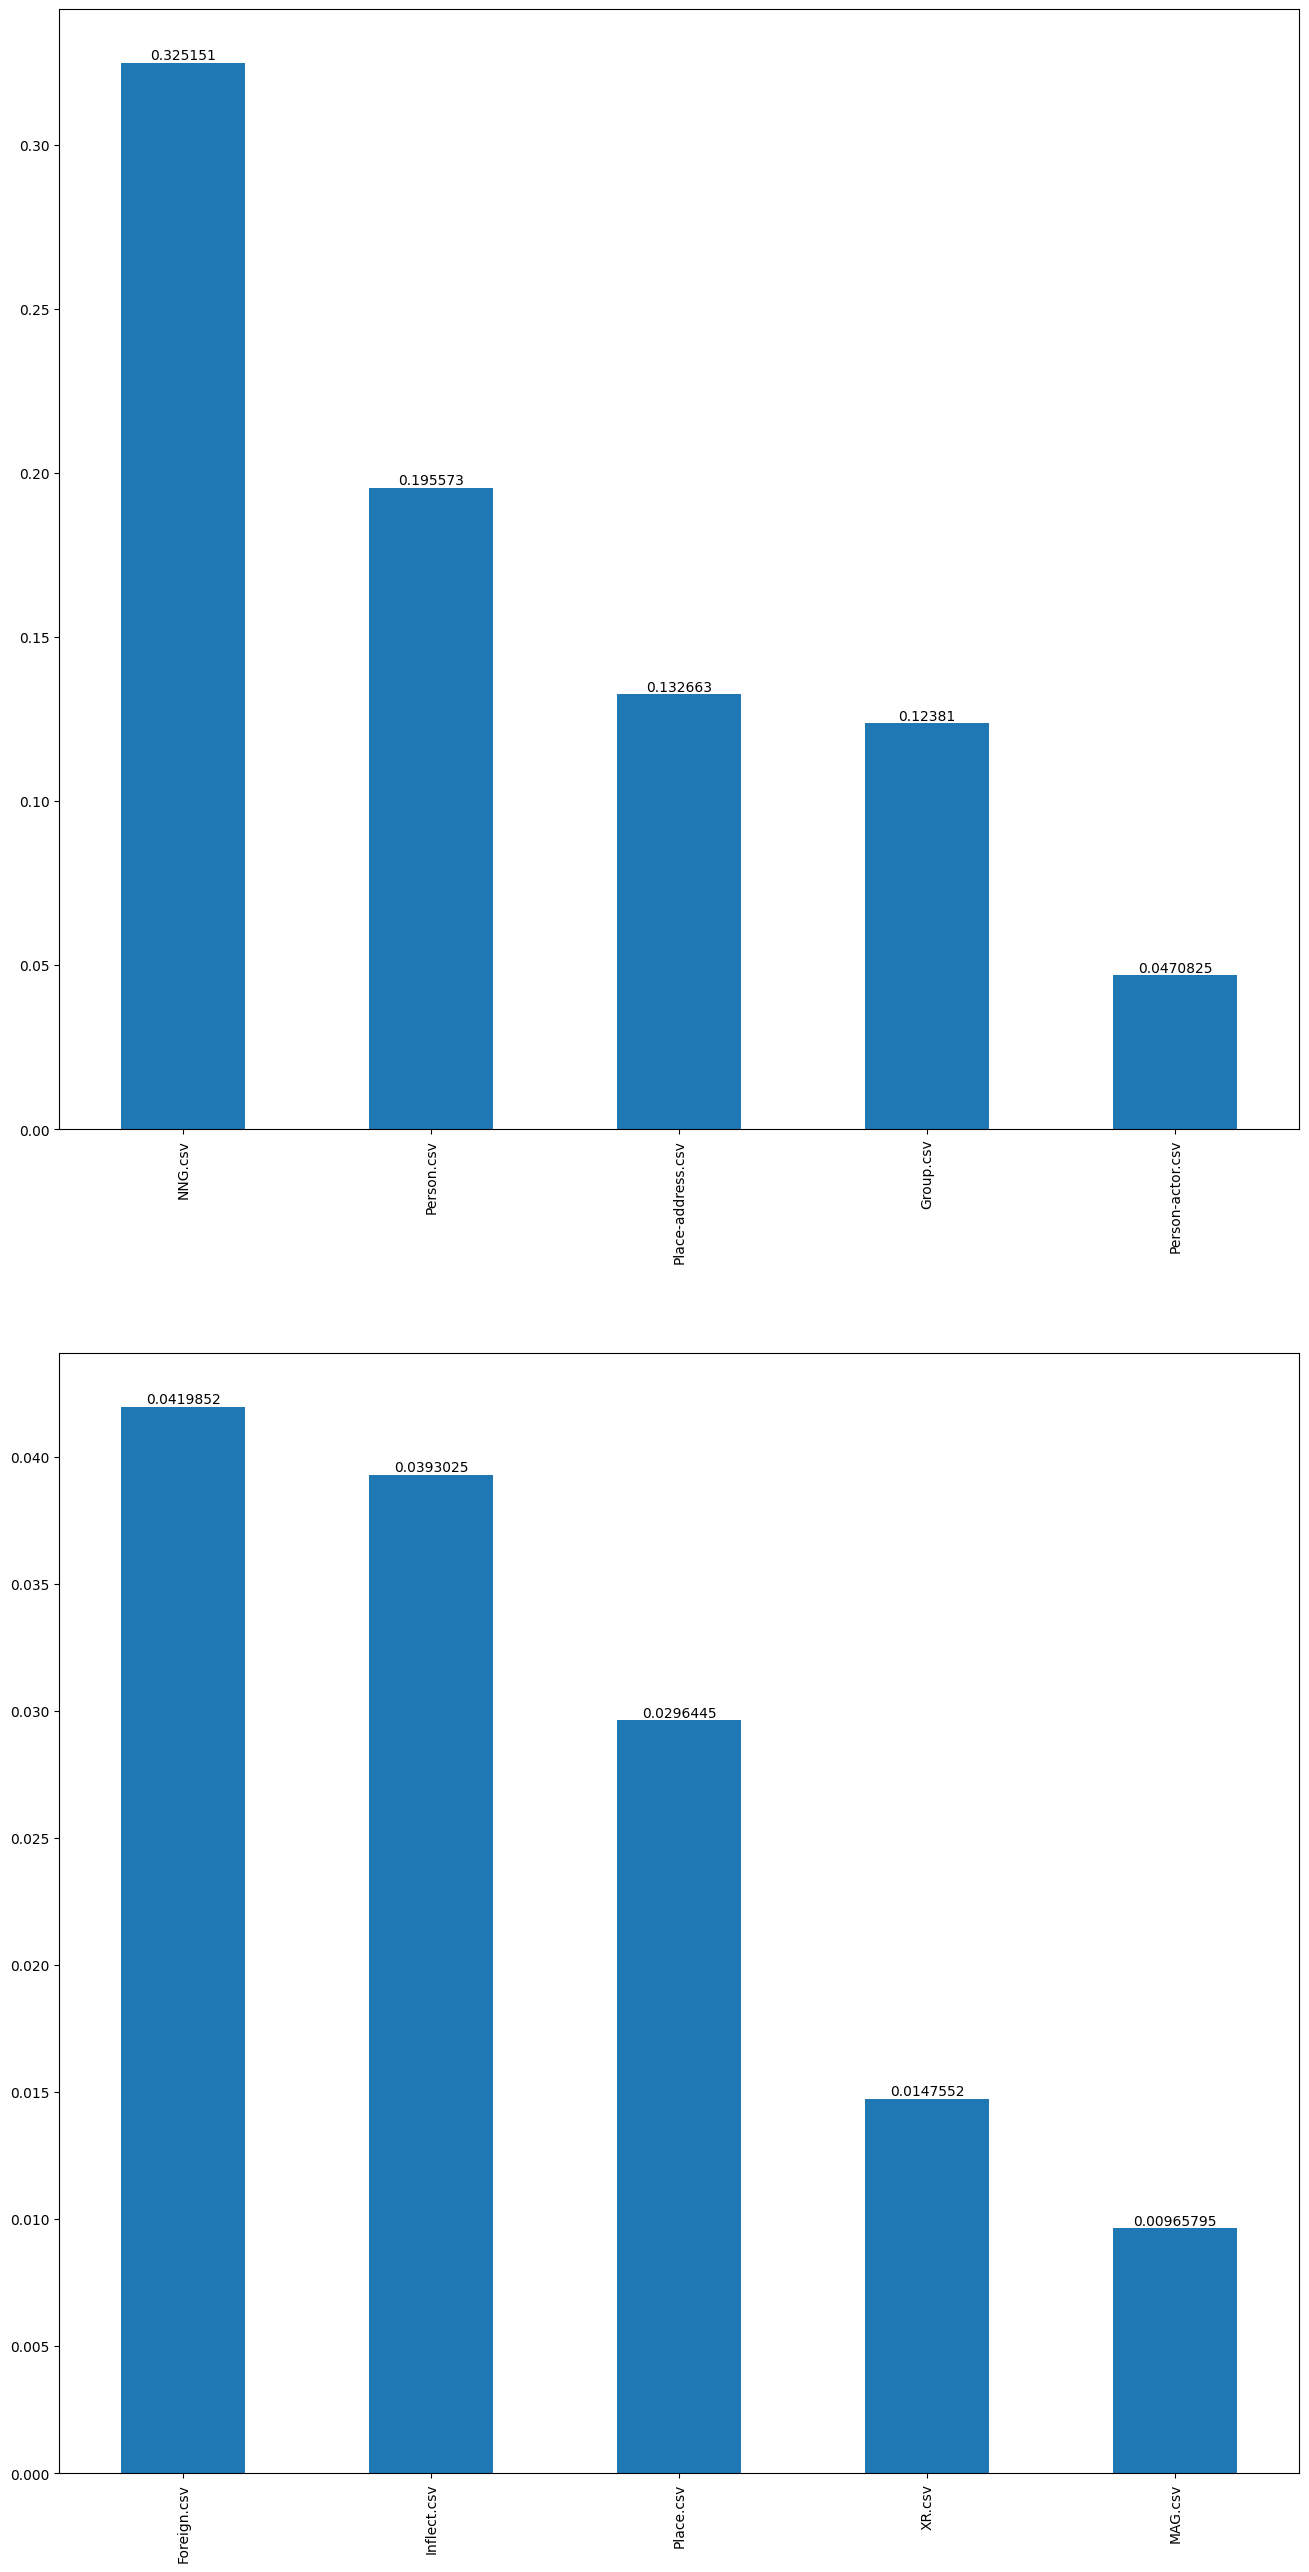

In [20]:
barchart_group_size = 5
num_images = 2 # math.ceil(homonyms['소스'].unique().shape[0]/barchart_group_size)

fig, axs = plt.subplots(num_images)

for idx in range(num_images):
    head_idx = barchart_group_size * idx
    tail_idx = head_idx + barchart_group_size
    ax = homonyms['소스'].value_counts(normalize=True)[head_idx:tail_idx].plot(figsize=(16, 32), kind='bar', ax=axs[idx])
    res = ax.bar_label(ax.containers[0])